In [869]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import librosa

1. Optimal K for PLSI

In [805]:
faces = np.load('faces.npy')

In [806]:
faces.shape

(441, 8)

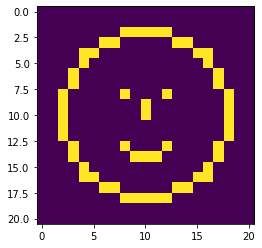

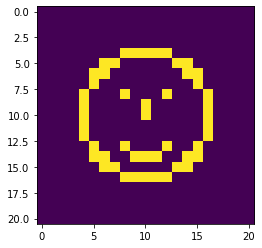

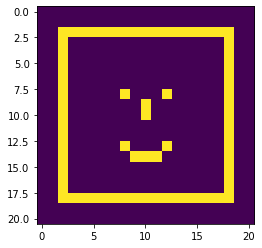

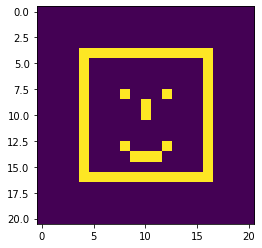

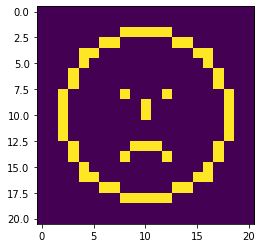

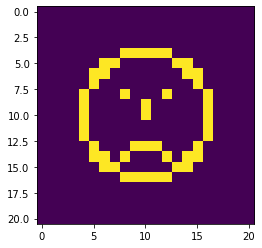

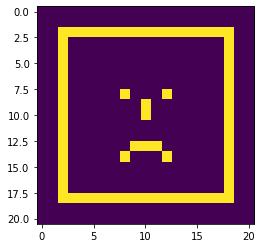

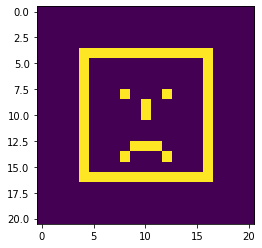

In [807]:
for i in range(8):
    plt.figure()
    plt.imshow(faces[:,i].reshape(21,21))

In [808]:
B = np.random.uniform(low = 0.0, high = 1.0, size = (441,6))

In [809]:
B.shape

(441, 6)

In [810]:
th = np.random.uniform(low = 0.0, high = 1.0, size = (6,8))

In [811]:
th.shape

(6, 8)

In [812]:
V = np.ones(shape = (441,441))
K = np.ones(shape = (6,6))

In [813]:
error_arr = np.zeros(1000)

In [814]:
B = B/((V@B) + 10**-20)
th = th/((K@th) + 10**-20)

In [815]:
for i in range(1000):
    error_arr[i] = np.sum((faces) * (np.log((faces + 10**-20)/(B@th + 10**-20)))) 
    B = B * ((faces/((B@th)+ 10**-20))@th.T)
    th = th * (B.T@(faces/((B@th)+ 10**-20)))
    B = B/((V@B) + 10**-20)
    th = th/((K@th) + 10**-20)


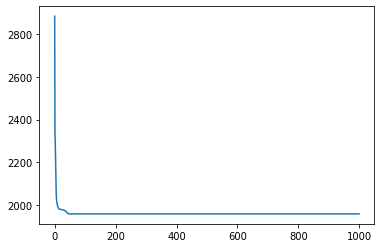

In [816]:
plt.plot(error_arr)

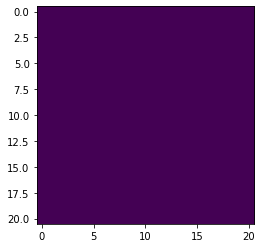

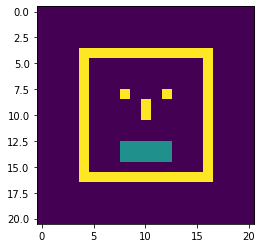

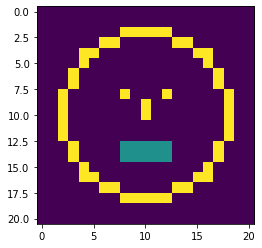

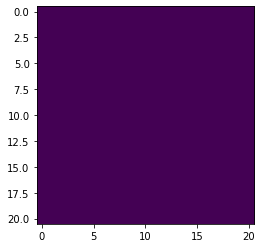

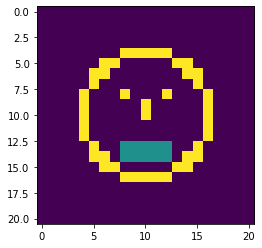

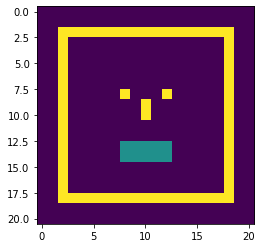

In [817]:
for i in range(6):
    plt.figure()
    plt.imshow(B[:,i].reshape(21,21))

In [818]:
th.shape

(6, 8)

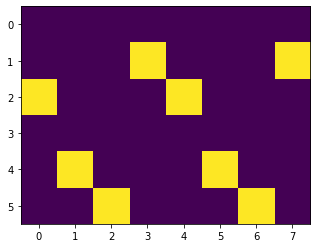

In [819]:
plt.imshow(th)

In [820]:
faces_recon = B@th

In [821]:
faces_recon.shape

(441, 8)

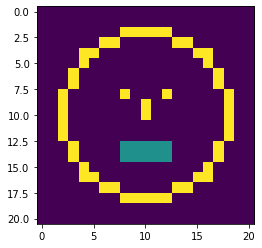

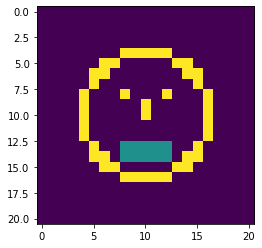

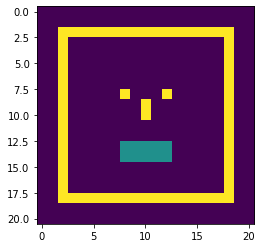

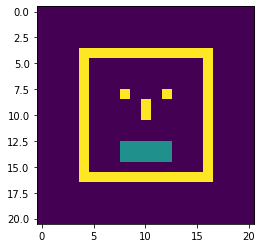

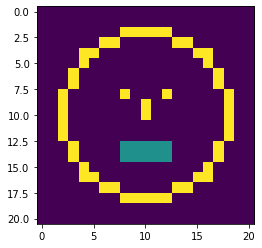

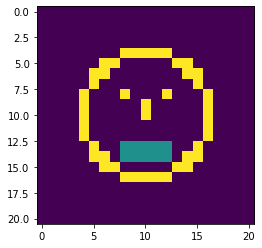

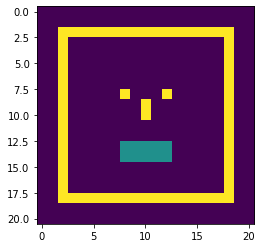

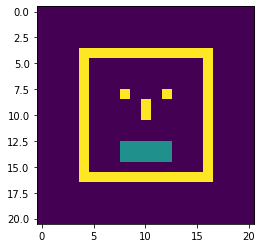

In [822]:
for i in range(8):
    plt.figure()
    plt.imshow(faces_recon[:,i].reshape(21,21))

2. Stereo Matching (Revisited)

In [902]:
import matplotlib.image as mpimg

img_l = mpimg.imread('im0.ppm')

img_r = mpimg.imread('im8.ppm')

img_r.shape

D = np.random.rand(381,390)

a = np.array(img_l[0,1])

b = np.array(img_r[0,1])

ld = 0
ld1 = 0
lid = 0

for i in range(381):
    for j in range(390):
        for k in range(40):
            for l in range(3):
                if img_r[i,j,l] > img_l[i,j+k,l]:
                    ld1 = ld1 + (img_r[i,j,l] - img_l[i,j+k,l])**2
                else:
                    ld1 = ld1 + (img_l[i,j+k,l] - img_r[i,j,l])**2
            ld1 = np.sqrt(ld1)
            if k == 0:
                ld = ld1
                lid = 0
            else:
                if ld1 < ld:
                    ld = ld1
                    lid = k
            ld1 = 0
        D[i,j] = lid

for i in range(381):
    for j in range(390):
        D[i,j] = np.int(D[i,j])

D_vec = np.random.rand((381*390)) 

for i in range(390):
    D_vec[381*i:381*i+381] = D[:,i]

In [957]:
D

array([[ 2.,  7.,  0., ...,  1., 12.,  7.],
       [ 9.,  4.,  3., ..., 25.,  5., 10.],
       [ 3.,  8.,  7., ..., 30., 29., 10.],
       ...,
       [16., 27., 13., ..., 37., 39., 26.],
       [31., 35., 18., ..., 33., 31., 33.],
       [26., 25., 24., ..., 27., 32., 33.]])

In [874]:
D_vec.shape

(148590,)

In [927]:
n_arr = np.array(D_vec)

In [953]:
np.array_split(D, 4)[3].shape

(95, 390)

In [972]:
class GMM:
    '''
        This class is the implementation of the Gaussian Mixture Models 
        inspired by sci-kit learn implementation.
    '''
    def __init__(self, n_components, max_iter = 100, comp_names=None):
        
        self.n_componets = n_components
        self.max_iter = max_iter
        if comp_names == None:
            self.comp_names = [f"comp{index}" for index in range(self.n_componets)]
        else:
            self.comp_names = comp_names
        
        self.pi = [1/self.n_componets for comp in range(self.n_componets)]

    def multivariate_normal(self, X, mean_vector, covariance_matrix):
   
        return (2*np.pi)**(-len(X)/2)*np.linalg.det(covariance_matrix)**(-1/2)*np.exp(-np.dot(np.dot((X-mean_vector).T, np.linalg.inv(covariance_matrix)), (X-mean_vector))/2)

    def fit(self, X):

        new_X = np.array_split(X, self.n_componets)
        self.mean_vector = [np.mean(x, axis=0) for x in new_X]
        self.covariance_matrixes = [np.cov(x.T) for x in new_X]
        del new_X
        for iteration in range(self.max_iter):
            
            self.r = np.zeros((len(X), self.n_componets))
            for n in range(len(X)):
                for k in range(self.n_componets):
                    self.r[n][k] = self.pi[k] * self.multivariate_normal(X[n], self.mean_vector[k], self.covariance_matrixes[k])
                    self.r[n][k] /= sum([self.pi[j]*self.multivariate_normal(X[n], self.mean_vector[j], self.covariance_matrixes[j]) for j in range(self.n_componets)])
            N = np.sum(self.r, axis=0)
        
            self.mean_vector = np.zeros((self.n_componets, len(X[0])))
            for k in range(self.n_componets):
                for n in range(len(X)):
                    self.mean_vector[k] += self.r[n][k] * X[n]
            self.mean_vector = [1/N[k]*self.mean_vector[k] for k in range(self.n_componets)]
            self.covariance_matrixes = [np.zeros((len(X[0]), len(X[0]))) for k in range(self.n_componets)]
            for k in range(self.n_componets):
                self.covariance_matrixes[k] = np.cov(X.T, aweights=(self.r[:, k]), ddof=0)
            self.covariance_matrixes = [1/N[k]*self.covariance_matrixes[k] for k in range(self.n_componets)]
            self.pi = [N[k]/len(X) for k in range(self.n_componets)]
            
    def predict(self, X):
        probas = []
        for n in range(len(X)):
            probas.append([self.multivariate_normal(X[n], self.mean_vector[k], self.covariance_matrixes[k])
                           for k in range(self.n_componets)])
        cluster = []
        for proba in probas:
            cluster.append(self.comp_names[proba.index(max(proba))])
        return cluster

In [973]:
gmm = GMM(4,10)

In [974]:
gmm.fit(D)

C:\Users\Siddhesh\anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Siddhesh\anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Siddhesh\anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp
C:\Users\Siddhesh\anaconda3\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in double_scalars


KeyboardInterrupt: 

In [959]:
gmm.max_iter

10

In [885]:
D_vec.size

148590

In [907]:
D

array([[ 2.,  7.,  0., ...,  1., 12.,  7.],
       [ 9.,  4.,  3., ..., 25.,  5., 10.],
       [ 3.,  8.,  7., ..., 30., 29., 10.],
       ...,
       [16., 27., 13., ..., 37., 39., 26.],
       [31., 35., 18., ..., 33., 31., 33.],
       [26., 25., 24., ..., 27., 32., 33.]])

In [909]:
D_vec.dtype

dtype('float64')

In [921]:
np.linalg.inv(D[0:2,0:2])

array([[-0.07272727,  0.12727273],
       [ 0.16363636, -0.03636364]])

3. Rock or Metal

In [1216]:
rom = sio.loadmat('trX.mat')

In [1217]:
rom1 = sio.loadmat('trY.mat')

In [1218]:
rom_data = rom['trX']

In [1219]:
rom_data.shape

(2, 160)

In [1220]:
rom_labels = rom1['trY']

In [1221]:
y = rom_labels.reshape(160)

In [1222]:
from typing import Optional
import matplotlib as mpl

In [1300]:
def plot_adaboost(X: np.ndarray,
                  y: np.ndarray,
                  clf=None,
                  sample_weights: Optional[np.ndarray] = None,
                  annotate: bool = False,
                  ax: Optional[mpl.axes.Axes] = None) -> None:
    """ Plot ± samples in 2D, optionally with decision boundary """

   # assert set(y) == {-1, 1}, 'Expecting response labels to be ±1'

    if not ax:
        fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
        fig.set_facecolor('white')

    pad = 1
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad

    if sample_weights is not None:
        sizes = np.array(sample_weights) * X.shape[0] * 100
    else:
        sizes = np.ones(shape=X.shape[0]) * 100

    X_pos = X[y == 1]
    sizes_pos = sizes[y == 1]
    ax.scatter(*X_pos.T, s=sizes_pos, marker='+', color='red')

    X_neg = X[y == -1]
    sizes_neg = sizes[y == -1]
    ax.scatter(*X_neg.T, s=sizes_neg, marker='.', c='blue')

    if clf:
        plot_step = 0.01
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # If all predictions are positive class, adjust color map acordingly
        if list(np.unique(Z)) == [1]:
            fill_colors = ['r']
        else:
            fill_colors = ['b', 'r']

        ax.contourf(xx, yy, Z, colors=fill_colors, alpha=0.2)

    if annotate:
        for i, (x, y) in enumerate(X):
            offset = 0.05
            ax.annotate(f'$x_{i + 1}$', (x + offset, y - offset))

    ax.set_xlim(-0.025, 0.15)
    ax.set_ylim(0, 0.4)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

In [1224]:
rom_data = rom_data.transpose()

In [1225]:
rom_data.shape

(160, 2)

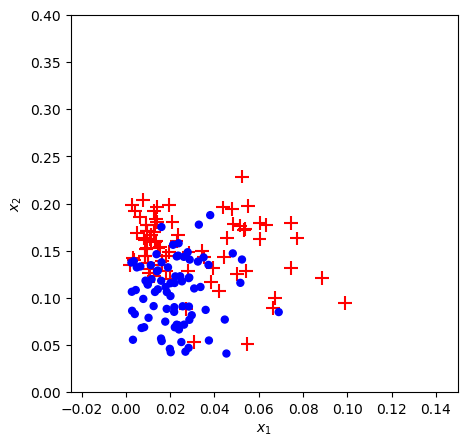

In [1226]:
plot_adaboost(rom_data,y)

In [1286]:
class tanh_Perceptron:
    def __init__(self):
        self.weight = np.zeros(shape = (1,2))
        
    def fit(self, X: np.ndarray, y: np.ndarray, W: np.ndarray):
        W1 = np.random.uniform(low = -0.5,high = 0.5,size = (1,3))
        ones = np.ones(160)
        X = X.T
        X = np.concatenate((X,ones.reshape(1,160)))
        rho = 0.001
        y_predicted = np.zeros(shape = (1,160))
        error_neural_arr = np.random.rand(160)
        for epoch in range(100):
            for i in range(160):
                y_predicted[:,i] = np.tanh(W1@X[:,i])
                error_neural_arr[i] = W[i]*((y[:,i] - y_predicted[:,i])**2)
                if (error_neural_arr[i] != 0):
                    del1 = np.sum(W[i] * 2 * (y[:,i] - y_predicted[:,i]) * (y[:,i] - (1 - y[:,1])))
                W1 = W1 - (rho * del1)
        self.weight = W1
        return self
        
    def predict_1(self, X):
        ones = np.ones(160)
        X = X.T
        X = np.concatenate((X,ones.reshape(1,160)))
        y_predicted = np.sign(np.tanh(self.weight@X))
        return y_predicted

In [1287]:
class AdaBoost:
    
    def __init__(self):
        self.stumps = None
        self.stump_weights = None
        self.errors = None
        self.sample_weights = None

    def _check_X_y(self, X, y):
       
        assert set(y) == {-1, 1}, 
        return X, y
    
    def fit(self, X: np.ndarray, y: np.ndarray, iters: int):

        n = X.shape[0]


        self.sample_weights = np.zeros(shape=(iters, n))
        self.stumps = np.zeros(shape=iters, dtype=object)
        self.stump_weights = np.zeros(shape=iters)
        self.errors = np.zeros(shape=iters)

        self.sample_weights[0] = np.ones(shape=n) / n

        for t in range(iters):

            curr_sample_weights = self.sample_weights[t]
            stump = tanh_Perceptron()
            stump = stump.fit(X, y, curr_sample_weights)


            stump_pred = stump.predict_1(X)
            err = 0
            for i in range(160):
                if stump_pred[:,i] != y[:,i]:
                    err = err + curr_sample_weights[i]
            stump_weight = np.log((1 - err) / err) / 2

            new_sample_weights = (curr_sample_weights * np.exp(-stump_weight * y * stump_pred))
        
            new_sample_weights /= new_sample_weights.sum()

            if t+1 < iters:
                self.sample_weights[t+1] = new_sample_weights


            self.stumps[t] = stump
            self.stump_weights[t] = stump_weight
            self.errors[t] = err

        return self

    def predict(self, X):
        stump_preds = np.array([stump.predict_1(X).reshape(160) for stump in self.stumps])
        return np.sign(np.dot(self.stump_weights.reshape(1,10), stump_preds))

In [1288]:
adaBoost = AdaBoost()

In [1289]:
adaBoost = adaBoost.fit(rom_data,rom_labels,10)

In [1290]:
y_final = adaBoost.predict(rom_data)

In [1296]:
y_final = y_final.reshape(160)

In [1301]:
y_final

array([-1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1., -1., -1., -1.,
       -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1., -1., -1.,  1.,
       -1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1., -1., -1., -1., -1.,
        1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1., -1.,  1.,
       -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.])

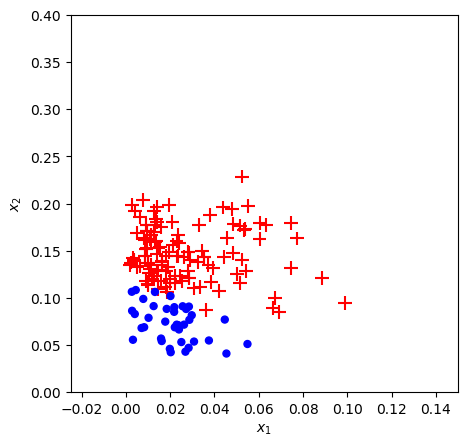

In [1302]:
plot_adaboost(rom_data,y_final)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

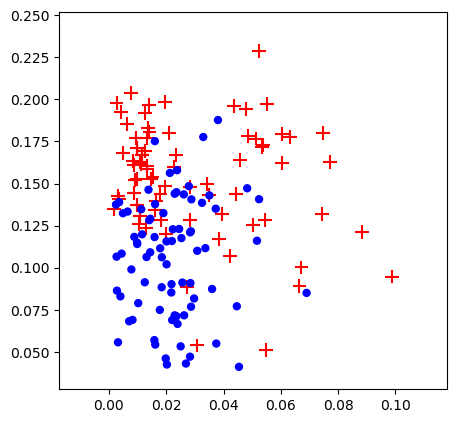

In [1308]:
plot_adaboost(rom_data, y, y_final)

4. PLSI for Analyzing Twitter Stream

In [423]:
import scipy.io as sio

In [476]:
tweets = sio.loadmat('twitter.mat')

In [477]:
tweets

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Sat Apr  8 02:28:48 2017',
 '__version__': '1.0',
 '__globals__': [],
 'Xte': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'Xtr': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'YteMat': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
         0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         1,

In [823]:
Xtr = tweets['Xtr']

In [824]:
Xtr.shape

(891, 773)

In [825]:
B1 = np.random.uniform(low = 0.0, high = 1.0, size = (891,50))
th1 = np.random.uniform(low = 0.0, high = 1.0, size = (50,773))

In [826]:
V1 = np.ones(shape = (891,891))
K1 = np.ones(shape = (50,50))

In [827]:
error_arr1 = np.zeros(1000)

In [828]:
B1 = B1/((V1@B1) + 10**-20)
th1 = th1/((K1@th1) + 10**-20)

In [829]:
S1 = B1@th1

In [830]:
for i in range(1000):
    error_arr1[i] = np.sum((Xtr) * (np.log((Xtr + 10**-20)/(B1@th1 + 10**-20)))) 
    B1 = B1 * ((Xtr/((B1@th1)+ 10**-20))@th1.T)
    th1 = th1 * (B1.T@(Xtr/((B1@th1)+ 10**-20)))
    B1 = B1/((V1@B1) + 10**-20)
    th1 = th1/((K1@th1) + 10**-20)

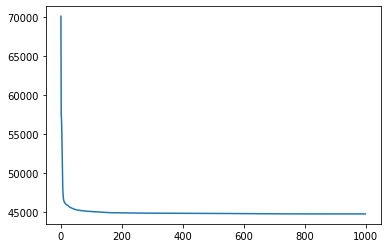

In [831]:
plt.plot(error_arr1)

In [832]:
B1.shape

(891, 50)

In [833]:
Xte = tweets['Xte']

In [834]:
Xte.shape

(891, 193)

In [835]:
th2 = np.random.uniform(low = 0.0, high = 1.0, size = (50,193))

In [836]:
th2 = th2/((K1@th2) + 10**-20)

In [837]:
error_arr2 = np.zeros(1000)

In [838]:
for i in range(1000):
    error_arr2[i] = np.sum((Xte) * (np.log((Xte + 10**-20)/(B1@th2 + 10**-20)))) 
    th2 = th2 * (B1.T@(Xte/((B1@th2)+ 10**-20)))
    th2 = th2/((K1@th2) + 10**-20)

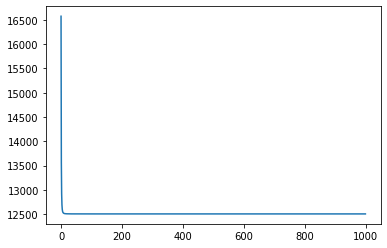

In [839]:
plt.plot(error_arr2)

In [840]:
def softmax(vector):
    e = np.exp(vector)
    return e / e.sum()

In [841]:
th1.shape

(50, 773)

In [842]:
Ytr = tweets['YtrMat']
Yte = tweets['YteMat']

In [843]:
Ytr = Ytr + 10**-20

In [844]:
ones = np.ones(773)
th1 = np.concatenate((th1,ones.reshape(1,773)))

In [845]:
th1.shape

(51, 773)

In [852]:
W = np.random.uniform(low = -0.5,high = 0.5,size = (3,51))

In [853]:
rho = 0.001

In [854]:
error_epochs = np.zeros(5000)

In [855]:
y_predicted = np.zeros(shape = (3,773))

In [856]:
error_neural_arr = np.random.rand(773)

In [857]:
for epoch in range(5000):
    for i in range(773):
        y_predicted[:,i] = softmax(W@th1[:,i])
        error_neural_arr[i] = -1 * np.sum(Ytr[:,i] * np.log(y_predicted[:,i])) 
        if (error_neural_arr[i] != 0):
            del1 = (y_predicted[:,i] - Ytr[:,i]).reshape(3,1) @ (th1[:,i].reshape(1,51))
            W = W - (rho * del1)
    error_epochs[epoch] = np.sum(error_neural_arr)

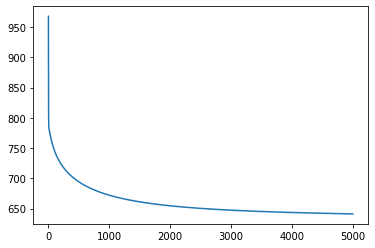

In [858]:
plt.plot(error_epochs)

In [859]:
th2.shape

(50, 193)

In [860]:
y_te_pred = np.zeros(shape = (3,193))

In [861]:
for i in range(193):
    y_te_pred[:,i] = softmax(W[:,0:50]@th2[:,i])

In [862]:
import tensorflow as tf

In [863]:
tf.argmax(y_te_pred)

<tf.Tensor: id=86, shape=(193,), dtype=int64, numpy=
array([0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 2, 0, 1, 0, 0,
       2, 0, 0, 1, 1, 0, 0, 1, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1,
       1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 2, 0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       2, 1, 0, 0, 1, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 1,
       0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 2, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 2, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0], dtype=int64)>

In [864]:
tf.argmax(Yte)

<tf.Tensor: id=89, shape=(193,), dtype=int64, numpy=
array([1, 2, 2, 1, 2, 2, 1, 1, 2, 0, 2, 2, 0, 0, 2, 1, 2, 2, 2, 1, 2, 2,
       1, 2, 2, 2, 1, 1, 0, 2, 2, 2, 2, 1, 0, 1, 2, 2, 2, 0, 2, 2, 1, 1,
       2, 0, 2, 2, 1, 0, 0, 1, 1, 2, 1, 0, 2, 0, 2, 2, 2, 0, 1, 2, 2, 2,
       2, 2, 0, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2,
       2, 2, 2, 0, 1, 1, 0, 1, 2, 2, 2, 1, 1, 1, 0, 1, 1, 2, 2, 2, 2, 2,
       0, 1, 2, 2, 2, 1, 2, 1, 1, 1, 0, 2, 2, 1, 2, 0, 0, 2, 0, 1, 2, 2,
       2, 0, 2, 2, 2, 0, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 0, 2, 1, 1, 0,
       2, 2, 2, 2, 1, 2, 0, 1, 0, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 0, 1, 1,
       2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2], dtype=int64)>

In [865]:
tf.argmax(Ytr)

<tf.Tensor: id=92, shape=(773,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [866]:
from sklearn.metrics import classification_report,accuracy_score

In [867]:
accuracy_score(tf.argmax(Yte),tf.argmax(y_te_pred))

0.32642487046632124

In [868]:
accuracy_score(tf.argmax(Ytr),tf.argmax(y_predicted))

0.5912031047865459